Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


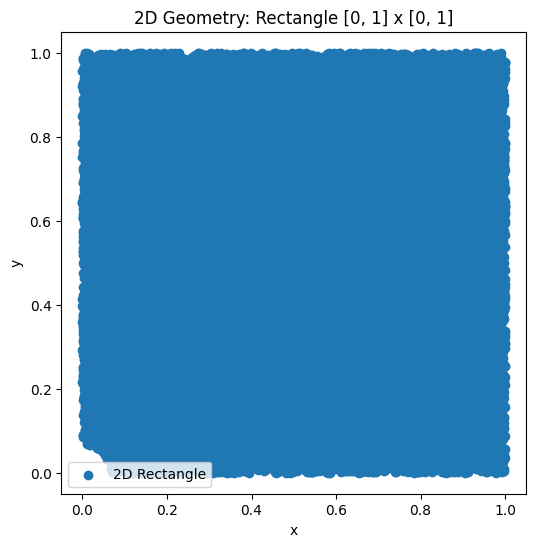

Compiling model...
'compile' took 0.025024 s

Training model...

Step      Train loss    Test loss     Test metric
0         [2.52e+03]    [2.63e+03]    []  
1000      [1.33e+03]    [1.39e+03]    []  
2000      [1.07e+03]    [1.11e+03]    []  
3000      [8.93e+02]    [9.22e+02]    []  
4000      [7.84e+02]    [7.99e+02]    []  
5000      [7.25e+02]    [7.29e+02]    []  
6000      [7.00e+02]    [6.95e+02]    []  
7000      [6.94e+02]    [6.84e+02]    []  
8000      [6.93e+02]    [6.81e+02]    []  
9000      [3.81e+02]    [3.93e+02]    []  
10000     [2.16e+02]    [2.35e+02]    []  
11000     [1.52e+02]    [1.68e+02]    []  
12000     [1.14e+02]    [1.26e+02]    []  
13000     [8.49e+01]    [9.41e+01]    []  
14000     [6.29e+01]    [6.98e+01]    []  
15000     [4.59e+01]    [5.09e+01]    []  
16000     [3.28e+01]    [3.62e+01]    []  
17000     [2.29e+01]    [2.51e+01]    []  
18000     [1.55e+01]    [1.68e+01]    []  
19000     [1.01e+01]    [1.07e+01]    []  
20000     [6.22e+00]    [

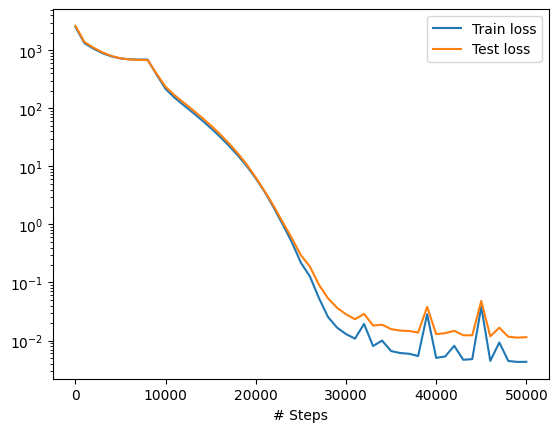

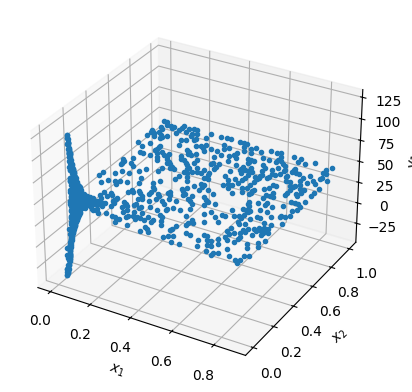

Compiling model...
'compile' took 0.002242 s

Training model...

Cause: could not parse the source code of <function <lambda> at 0x0000025B4EC6CB80>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000025B4EC6CB80>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @

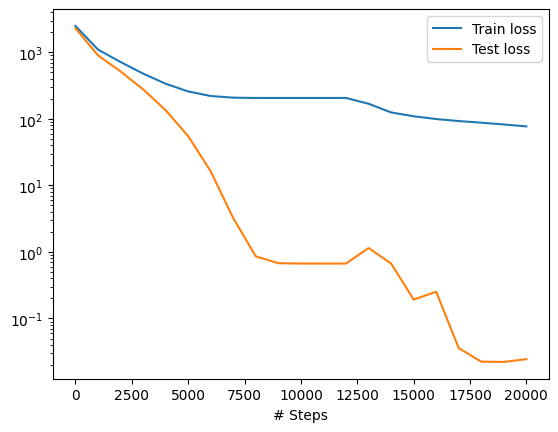

In [1]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import deepxde as dde
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt


L =1#m
R= 4e-3/6e-2 #m
t_last=1 #s
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
Samp = geom.random_points(30000)
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
n = 2000 
sampled_data = df.sample(n=n)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for te

data_x=np.column_stack((x_train,y_train))/6e-2
data_sigma=np.array(sigma_train)/10**6
test_x=np.column_stack((x_test,y_test))/6e-2
test_sigma=np.array(sigma_test)/10**6

data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)
layer_size = [2] + [64] * 8 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "tanh"
initializer = "Glorot uniform"
#activation="relu"
#initializer = "He normal"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)
model_sigma = dde.Model(data, net_sigma)
model_sigma.compile("adam", lr=1e-4)
losshistory, train_state = model_sigma.train(epochs=50000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

net_sigma.trainable = False

ic = dde.icbc.IC(geomtime, lambda x: 20.0, lambda x, on_initial: on_initial, component=0)

def pde_C_L(x, y):
    D_L = 3.8e-1 #m^2/s
    V_H = 2e-6 #m^3/mole
    RT= 8.314*298 #J/mole
    Coe=(D_L*V_H)/(RT)
    C_L=y[:,0:1]
    Sig=y[:,1:2]
    dC_dt = dde.grad.jacobian(y, x, i=0, j=2)
    CL_x=dde.grad.jacobian( y, x, i=0, j=0)
    CL_y=dde.grad.jacobian( y, x, i=0, j=1)
    CL_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    
    cor = x[:, :2]  # Extract spatial coordinates
    #sigma_values = net_sigma(cor)/N
    sigma = net_sigma(cor)
    h_sigma_x = dde.grad.jacobian(Sig, x,i=0,j=0)
    h_sigma_y = dde.grad.jacobian(Sig, x,i=0,j=1)
    h_sigma_xx = dde.grad.jacobian(h_sigma_x, x,i=0,j=0)
    h_sigma_yy = dde.grad.jacobian(h_sigma_y, x,i=0,j=1)

    #h_sigma_x=dde.grad.jacobian(y,x,i=1,j=0)
    #h_sigma_y= dde.grad.jacobian(y,x,i=1,j=1)
    #h_sigma_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    #h_sigma_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    eq1 = (dC_dt - D_L * (CL_xx + CL_yy)+ Coe * (CL_x* h_sigma_x*1e6 + CL_y * h_sigma_y*1e6 + C_L * (h_sigma_xx*1e6 + h_sigma_yy*1e6)))
    eq3=Sig-sigma
    return [eq1,eq3]

data = dde.data.TimePDE(
    geomtime,
    pde_C_L, [ic],
    num_domain=800,
    num_boundary=500,
    num_initial=800,
    num_test=800,
    )

# Network for C_L
layer_size = [3] + [64] * 8 + [2]  
activation = "tanh"
initializer = "Glorot uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)
model= dde.Model(data, net_C_L)
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [52]:

df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
n = 3000 
sampled_data = df.sample(n=n)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values/10**6).reshape(-1, 1)  # Extract the sigma values for training
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values/10**6).reshape(-1, 1) # Extract the sigma values for te

print(sigma_train)

[[43.1389885]
 [43.2332268]
 [55.9036026]
 ...
 [43.467289 ]
 [43.5843506]
 [43.4085655]]


MovieWriter imagemagick unavailable; using Pillow instead.


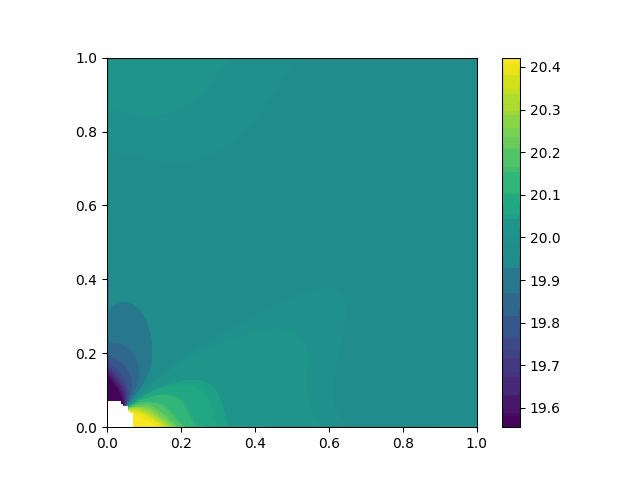

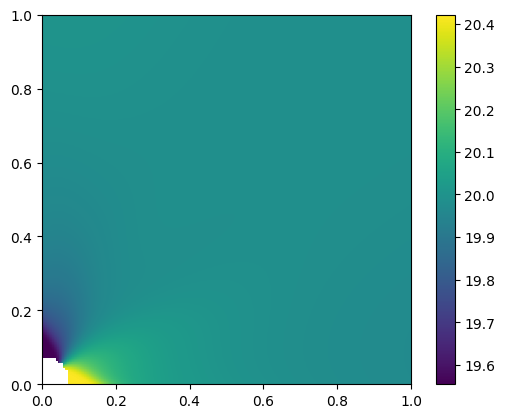

In [2]:
#Plot
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from IPython.display import display
length=1
resolution =150
radius = 4e-3/6e-2
time=1
t= np.linspace(0, time, resolution)
x = np.linspace(0, length, resolution)
y = np.linspace(0, length, resolution)
data = np.zeros((resolution,resolution, resolution))
# Generate frames for each time step
for h in range(resolution):
    for i in range(resolution):
        for j in range(resolution):
            # Pass individual x, y, t values to model.predict()
             prediction= model.predict([[x[i], y[j], t[h]]])[0][0]
             data[i, j , h]=prediction
             if (x[i]**2 + y[j]**2) < radius**2:
                 data[i,j,h]=None
            
    # Apply mask for the central hole
    

    
# Initialize the plot
fig, ax = plt.subplots()
data = np.transpose(data, (1, 0, 2))
contour = ax.imshow(data[:,:,0], extent=[0, length, 0, length], origin="lower", cmap="viridis")
fig.colorbar(contour)

# Update function for each frame
def update(frame):
    contour.set_data(data[:,:,frame])
    return [contour]

# Create the animation
anim = FuncAnimation(fig, update, frames=resolution, interval=500, blit=True)
anim.save("animation.gif", writer="imagemagick")
# Display the animation
display(Image(filename="animation.gif"))

Compiling model...
'compile' took 0.003648 s

Training model...

Step      Train loss    Test loss     Test metric
0         [2.60e+03]    [2.67e+03]    []  
1000      [1.41e+03]    [1.44e+03]    []  
2000      [1.13e+03]    [1.15e+03]    []  
3000      [9.37e+02]    [9.42e+02]    []  
4000      [8.09e+02]    [8.05e+02]    []  
5000      [7.35e+02]    [7.22e+02]    []  
6000      [7.00e+02]    [6.80e+02]    []  
7000      [6.89e+02]    [6.64e+02]    []  
8000      [6.88e+02]    [6.60e+02]    []  
9000      [6.88e+02]    [6.59e+02]    []  
10000     [6.88e+02]    [6.59e+02]    []  
11000     [3.93e+02]    [4.06e+02]    []  
12000     [2.23e+02]    [2.23e+02]    []  
13000     [1.55e+02]    [1.53e+02]    []  
14000     [1.15e+02]    [1.13e+02]    []  
15000     [8.60e+01]    [8.34e+01]    []  
16000     [6.36e+01]    [6.12e+01]    []  
17000     [4.62e+01]    [4.42e+01]    []  
18000     [3.27e+01]    [3.14e+01]    []  
19000     [2.25e+01]    [2.16e+01]    []  
20000     [1.49e+01]    [

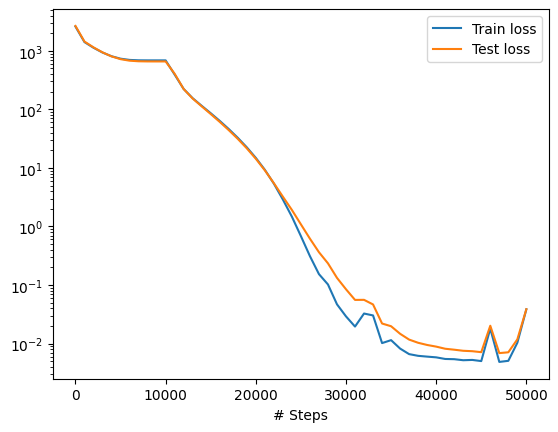

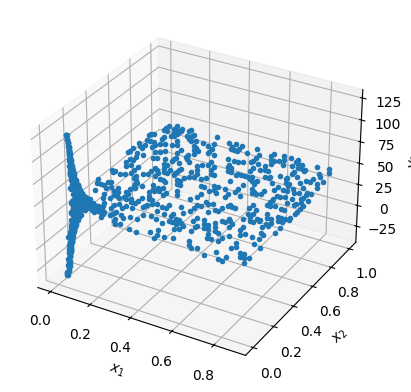

In [ ]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import deepxde as dde
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
n = 2000 
sampled_data = df.sample(n=n)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)
x_train = np.array(train_data['x'].values).reshape(-1, 1)  # Extract the x values for training
y_train = np.array(train_data['y'].values).reshape(-1, 1)   # Extract the y values for training
sigma_train =np.array(train_data['sigma'].values).reshape(-1, 1)  # Extract the sigma values for training
x_test = np.array(test_data['x'].values).reshape(-1, 1)  # Extract the x values for testing
y_test = np.array(test_data['y'].values).reshape(-1, 1)  # Extract the y values for testing
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1) # Extract the sigma values for te

data_x=np.column_stack((x_train,y_train))/6e-2
data_sigma=np.array(sigma_train)/10**6
test_x=np.column_stack((x_test,y_test))/6e-2
test_sigma=np.array(sigma_test)/10**6

data = dde.data.dataset.DataSet(X_train=data_x, y_train=data_sigma, X_test=test_x, y_test=test_sigma)
layer_size = [2] + [64] * 8 + [1]  # 2 inputs (x, y ) -> hidden layers -> 1 output (σ)
activation = "tanh"
initializer = "Glorot uniform"
#activation="relu"
#initializer = "He normal"
net_sigma = dde.nn.FNN(layer_size, activation,initializer)
model_sigma = dde.Model(data, net_sigma)
model_sigma.compile("adam", lr=1e-4)
losshistory, train_state = model_sigma.train(epochs=50000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

<function matplotlib.pyplot.show(close=None, block=None)>

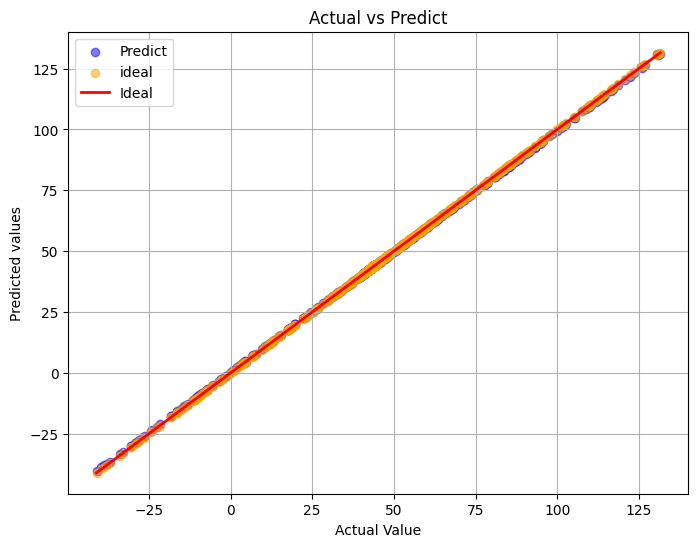

In [74]:
predict_s=model_sigma.predict(test_x)
plt.figure(figsize=(8,6))
plt.scatter(test_sigma,predict_s, color='blue',label='Predict', alpha=0.5)
plt.scatter(test_sigma,test_sigma, color='orange',label='ideal', alpha=0.5)
plt.plot([min(test_sigma),max(test_sigma)],[min(test_sigma),max(test_sigma)], color='red',label="Ideal",linewidth=2)
plt.title("Actual vs Predict")
plt.xlabel("Actual Value")
plt.ylabel("Predicted values")
plt.legend()
plt.grid(True)
plt.show

In [76]:
testing=model_sigma.predict([[0.014598/6e-2,0.014112/6e-2]])*1e6
#43584350.6
print(testing)
print(net_sigma([[0.014598/6e-2,0.014112/6e-2]]))

[[43539672.]]


ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 0.24330000000000002 (of type <class 'float'>)